# CNN with Fashion MNIST Dataset

Fashion-MNIST is a new dataset comprising of 28 × 28 grayscale images of 70,000 fashion products from 10 categories, with 7,000 images per category.

### Libraries

Let's first import some required packages.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import keras
from keras.datasets import fashion_mnist, mnist
from keras.models import Sequential,Input,Model, load_model
from keras.layers import Dense, Dropout, Flatten, SeparableConv2D
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.layers.advanced_activations import LeakyReLU
import sklearn.preprocessing as pre
from sklearn.model_selection import train_test_split
print("Keras version: {}".format(keras.__version__))
print("TensorFlow version: {}".format(tf.__version__))
%matplotlib inline

Using TensorFlow backend.


Keras version: 2.1.6
TensorFlow version: 1.8.0


### Loading Data

For the first time, `fashion_mnist` dataset will be downloaded from the Internet if there is no copy in the hard-drive.

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print("Train data shape: {0} | Train label shape: {1}".format(x_train.shape, y_train.shape))
print("Test data shape:  {0} | Test label shape:  {1}".format(x_test.shape, y_test.shape))

Train data shape: (60000, 28, 28) | Train label shape: (60000,)
Test data shape:  (10000, 28, 28) | Test label shape:  (10000,)


Sample values for first image. We can see that its values ranging from 0 to 255. Later in the preprocessing part we will normalize them.

In [4]:
print(x_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23

### Understanding Data

The next step is to understand more about our data. As we can see that there are 10 different classes in our training data ranging from `0` to `9` making up to total of 10. 

Each training and test example is assigned to one of the following labels:

<img src="./data/images/f_mnist.png" alt="Drawing" style="width: 65%;"/>

In [5]:
classes = np.unique(y_train)
num_classes = len(classes)
print("Output classes: {}".format(classes))
print("Total number of classes in our training example: {}".format(num_classes))
print("First 20 labels:{}".format(y_train[0:20]))

Output classes: [0 1 2 3 4 5 6 7 8 9]
Total number of classes in our training example: 10
First 20 labels:[9 0 0 3 0 2 7 2 5 5 0 9 5 5 7 9 1 0 6 4]


We will define a function to display image from dataset.

In [6]:
def display_image(data, label, width, height):
    '''
    Arguments:
        data: data image
        width: the width of display image (which is 28)
        height: the height of display image (which is also 28)
    Return:
        plot containing 20 images of our first 20 digits
    '''
    fig = plt.figure(figsize=(8, 8))
    for i in range(1, 21):
        fig.add_subplot(4, 5, i)
        new_image = data[i-1].reshape(width, height)
        lbl = label[i-1]
        plt.imshow(new_image, cmap=cm.binary)
        plt.title("Label: {}".format(lbl))
        plt.axis('off')

Below is the images of first 20 items in train dataset with their corresponding labels.

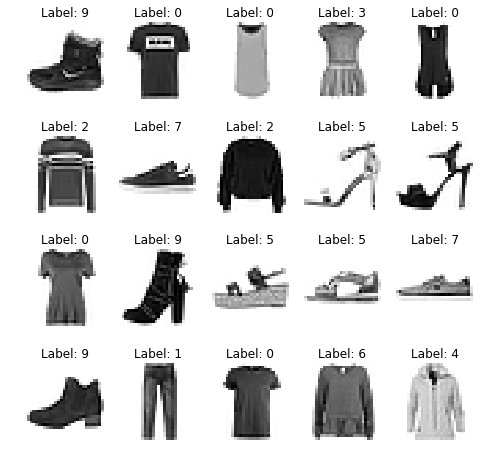

In [7]:
display_image(x_train, y_train, 28, 28)

### Preprocessing Data

#### Image Data

In order to feed data into Convolutional Layer, we first have to re-shape data into format accepted by Keras Conv2D. According to the Keras documentation, if we use this layer as a first layer in the mode, the keyword argument `input_shape` must be provided. Below is an example of feeding input of 128x128 RGB images using `data_format = "channels_last"`.

    input_shape = (128, 128, 3)

For greyscale images, replace `3` by `1` as there is only 1 channel. This is the same with our case.

In [8]:
x_train_reshape = x_train.reshape(-1, 28,28, 1)
x_test_reshape = x_test.reshape(-1, 28, 28, 1)

print("x_train new shape: {} | Data type: {}".format(x_train_reshape.shape, x_train_reshape.dtype))
print("x_test new shape:  {} | Data type: {}".format(x_test_reshape.shape, x_test_reshape.dtype))

x_train new shape: (60000, 28, 28, 1) | Data type: uint8
x_test new shape:  (10000, 28, 28, 1) | Data type: uint8


Next, we will convert data by dividing each value by 255 to re-range values from 0 to 1. However, the original values are in `uint8`, if we keep this format there will be data loss. Therefore, converting from `uint8` datatype to `float32` is required.

In [9]:
def convert_data(data):
    '''
    Arguments:
        data: raw data
    Return:
        array in the form of float values
    '''
    img = data.astype(np.float32)
    return np.multiply(img, 1.0 / 255.0) # Convert from [0:255] to [0.0:1.0]

In [10]:
x_train_convert = convert_data(x_train_reshape)
print("Done converting train data.")
x_test_convert = convert_data(x_test_reshape)
print("Done converting test data.")

Done converting train data.
Done converting test data.


In [11]:
print("x_train new shape: {} | Data type: {}".format(x_train_convert.shape, x_train_convert.dtype))
print("x_test new shape:  {} | Data type: {}".format(x_test_convert.shape, x_test_convert.dtype))
print("x_train datatype: {}".format(x_train_convert.dtype))
print("x_test datatype : {}".format(x_test_convert.dtype))
print("Sample data:\n {} ".format(x_train_convert[0]))

x_train new shape: (60000, 28, 28, 1) | Data type: float32
x_test new shape:  (10000, 28, 28, 1) | Data type: float32
x_train datatype: float32
x_test datatype : float32
Sample data:
 [[[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        

#### Label Data

In this part, we will convert label data into one-hot vectors so each label will contain one `1` value for its label and the rest will be `0`. Function `convert_to_one_hot` will be defined to do this task.

In [12]:
def convert_to_one_hot(labels_data, max_length):
    '''
    Arguments:
        labels_data: our raw data containing labels values
        max_length: the maximum columns of our one-hot vectors (class numbers)
    Return: 
        Labels in the form of one-hot vectors
    '''
    label_binarizer = pre.LabelBinarizer()
    label_binarizer.fit(range(max_length))
    one_hot_label = label_binarizer.transform(labels_data)
    one_hot_label = one_hot_label.astype(np.int32)
    return one_hot_label

In [13]:
y_train_one_hot = convert_to_one_hot(y_train,10)
print("Shape of train labels: {}".format(y_train_one_hot.shape))
print("First 5 train labels: \n{}\n".format(y_train_one_hot[0:5]))

y_test_one_hot = convert_to_one_hot(y_test,10)
print("Shape of test labels: {}".format(y_test_one_hot.shape))
print("First 5 test labels: \n{}".format(y_test_one_hot[0:5]))

Shape of train labels: (60000, 10)
First 5 train labels: 
[[0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]]

Shape of test labels: (10000, 10)
First 5 test labels: 
[[0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]]


### Splitting Data

Training data will be splitted into train and validation sets for training and validation purposes with the size of 15% of total for validation set and the rest for training set.


In [14]:
x_train_data, x_valid_data, y_train_data, y_valid_data = train_test_split(x_train_convert, 
                                                    y_train_one_hot, 
                                                    test_size = 0.15, 
                                                    random_state = 123)

print("Length of x_train: "+ str(x_train_data.shape))
print("Length of y_train: "+ str(y_train_data.shape) +"\n")
print("Shape of x_valid: "+ str(x_valid_data.shape))
print("Shape of y_valid: "+ str(y_valid_data.shape))

Length of x_train: (51000, 28, 28, 1)
Length of y_train: (51000, 10)

Shape of x_valid: (9000, 28, 28, 1)
Shape of y_valid: (9000, 10)


### Building CNN Network

In this part we will build 2 models by using no dropout and with dropout.

In [62]:
batch_size = 64
epochs = 20

#### Train without Drop-out

In [16]:
model_no_dropout = Sequential()
model_no_dropout.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(28,28,1),padding='same'))
model_no_dropout.add(MaxPooling2D((2, 2),padding='same'))
model_no_dropout.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model_no_dropout.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model_no_dropout.add(Conv2D(128, (3, 3), activation='relu',padding='same'))            
model_no_dropout.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model_no_dropout.add(Flatten())
model_no_dropout.add(Dense(128, activation='relu'))             
model_no_dropout.add(Dense(num_classes, activation='softmax'))

In [17]:
model_no_dropout.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
__________

In [18]:
model_no_dropout.compile(loss=keras.losses.categorical_crossentropy, 
                      optimizer=keras.optimizers.Adam(),
                      metrics=['accuracy'])

In [25]:
file_name = "./data/model/no_dropout_model.h5"
callbacks_list = [
        keras.callbacks.EarlyStopping(
            monitor='acc',
            patience=1
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=file_name,
            monitor='val_loss',
            save_best_only=True
)]
history_no_dropout = model_no_dropout.fit(x_train_data, y_train_data, 
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=1,
                         validation_data=(x_valid_data, y_valid_data),
                         callbacks = callbacks_list)

Train on 51000 samples, validate on 9000 samples
Epoch 1/20
51000/51000 [==============================] - 127s 2ms/step - loss: 0.2314 - acc: 0.9142 - val_loss: 0.2248 - val_acc: 0.9191
Epoch 2/20
51000/51000 [==============================] - 128s 3ms/step - loss: 0.2048 - acc: 0.9247 - val_loss: 0.2260 - val_acc: 0.9202
Epoch 3/20
51000/51000 [==============================] - 116s 2ms/step - loss: 0.1828 - acc: 0.9319 - val_loss: 0.2170 - val_acc: 0.9243
Epoch 4/20
51000/51000 [==============================] - 118s 2ms/step - loss: 0.1613 - acc: 0.9404 - val_loss: 0.2233 - val_acc: 0.9228
Epoch 5/20
51000/51000 [==============================] - 119s 2ms/step - loss: 0.1450 - acc: 0.9450 - val_loss: 0.2452 - val_acc: 0.9116
Epoch 6/20
51000/51000 [==============================] - 124s 2ms/step - loss: 0.1266 - acc: 0.9525 - val_loss: 0.2238 - val_acc: 0.9249
Epoch 7/20
51000/51000 [==============================] - 118s 2ms/step - loss: 0.1083 - acc: 0.9599 - val_loss: 0.2369 - v

In [67]:
def train_valid_plot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_ = range(1, len(acc) + 1)
    plt.plot(epochs_, acc, 'bo', label='Training acc')
    plt.plot(epochs_, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs_, loss, 'bo', label='Training loss')
    plt.plot(epochs_, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

Plotting training and validation accuracy/loss:

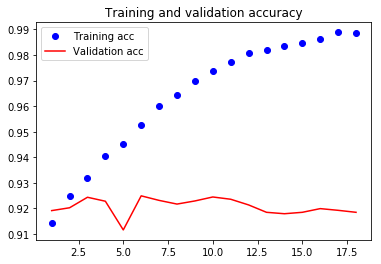

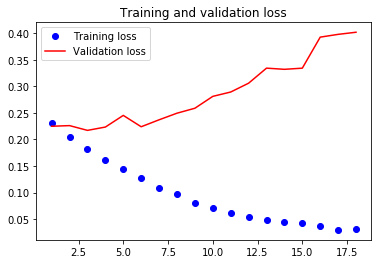

In [68]:
train_valid_plot(history_no_dropout)

In [27]:
test_eval = model_no_dropout.evaluate(x_test_convert, y_test_one_hot, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

10000/10000 [==============================] - 7s 700us/step
Test loss: 0.477305999657
Test accuracy: 0.9121


#### Train with Drop-out

In [63]:
model_dropout = Sequential()
model_dropout.add(Conv2D(32, kernel_size=(4, 4), padding='same', input_shape=(28,28,1), activation = 'relu'))
model_dropout.add(MaxPooling2D((2,2), padding = 'same'))
model_dropout.add(Dropout(0.1))
model_dropout.add(Conv2D(64, kernel_size = (4, 4), padding = 'same', activation = 'relu'))
model_dropout.add(MaxPooling2D((2,2), padding = 'same'))
model_dropout.add(Dropout(0.3))
model_dropout.add(Flatten())
model_dropout.add(Dense(256, activation = 'relu'))
model_dropout.add(Dropout(0.5))
model_dropout.add(Dense(64, activation = 'relu'))
model_dropout.add(Dense(num_classes, activation = 'softmax'))

In [64]:
model_dropout.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 32)        544       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 64)        32832     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 3136)              0         
__________

In [65]:
model_dropout.compile(loss=keras.losses.categorical_crossentropy, 
                      optimizer=keras.optimizers.Adam(),
                      metrics=['accuracy'])

In [66]:
file_name = "./data/model/dropout_model.h5"
callbacks_list_1 = [
        keras.callbacks.EarlyStopping(
            monitor='acc',
            patience=1
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=file_name,
            monitor='val_loss',
            save_best_only=True
)]
history_dropout = model_dropout.fit(x_train_data, y_train_data, 
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  verbose=1,
                                  validation_data=(x_valid_data, y_valid_data),
                                  callbacks = callbacks_list_1)

Train on 51000 samples, validate on 9000 samples
Epoch 1/20
51000/51000 [==============================] - 118s 2ms/step - loss: 0.5708 - acc: 0.7909 - val_loss: 0.3329 - val_acc: 0.8799
Epoch 2/20
51000/51000 [==============================] - 128s 3ms/step - loss: 0.3604 - acc: 0.8699 - val_loss: 0.2840 - val_acc: 0.8973
Epoch 3/20
51000/51000 [==============================] - 120s 2ms/step - loss: 0.3120 - acc: 0.8864 - val_loss: 0.2511 - val_acc: 0.9080
Epoch 4/20
51000/51000 [==============================] - 127s 2ms/step - loss: 0.2851 - acc: 0.8959 - val_loss: 0.2515 - val_acc: 0.9090
Epoch 5/20
51000/51000 [==============================] - 121s 2ms/step - loss: 0.2632 - acc: 0.9023 - val_loss: 0.2378 - val_acc: 0.9118
Epoch 6/20
51000/51000 [==============================] - 120s 2ms/step - loss: 0.2449 - acc: 0.9092 - val_loss: 0.2280 - val_acc: 0.9154
Epoch 7/20
51000/51000 [==============================] - 124s 2ms/step - loss: 0.2371 - acc: 0.9118 - val_loss: 0.2187 - v

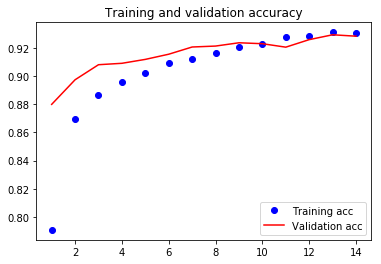

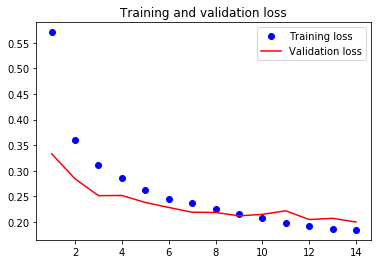

In [69]:
train_valid_plot(history_dropout)

In [71]:
model_saved = load_model("./data/model/dropout_model.h5")
test_saved = model_saved.evaluate(x_test_convert, y_test_one_hot, verbose=1)
print('Test loss:', test_saved[0])
print('Test accuracy:', test_saved[1])

10000/10000 [==============================] - 7s 665us/step
Test loss: 0.217738029987
Test accuracy: 0.9214


### References
- https://keras.io/layers/convolutional/#conv2d
- https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python
- https://arxiv.org/abs/1708.07747
- https://github.com/zalandoresearch/fashion-mnist